## Imports

In [22]:
import cv2
import numpy as np
import rawpy
import os
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load and display images (just to see them lol)

In [23]:
def load_image(image_path):
    ext = os.path.splitext(image_path)[-1].lower()
    if ext in ['.jpg', '.jpeg', '.png']:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif ext in ['.dng', '.nef', '.cr2']:  # RAW formats
        with rawpy.imread(image_path) as raw:
            image = raw.postprocess()
    else:
        raise ValueError("Unsupported file format")
    return image

In [24]:
DIR = "data/ricoh-dataset/"
image_diff = load_image(f"{DIR}ricoh_images_diff.jpg")
image_org = load_image(f"{DIR}ricoh_images_org.jpg")

image_diff_2 = load_image(f"{DIR}ricoh_images_diff_2.jpg")
image_org_2 = load_image(f"{DIR}ricoh_images_org_2.jpg")

image_diff_3 = load_image(f"{DIR}ricoh_images_diff_3.jpeg")
image_org_3 = load_image(f"{DIR}ricoh_images_org_3.jpeg")

image_diff_4 = load_image(f"{DIR}ricoh_images_diff_4.jpg")
image_org_4 = load_image(f"{DIR}ricoh_images_org_4.jpg")

The following pictures were taken by Ricoh IIIx with HDF off/on

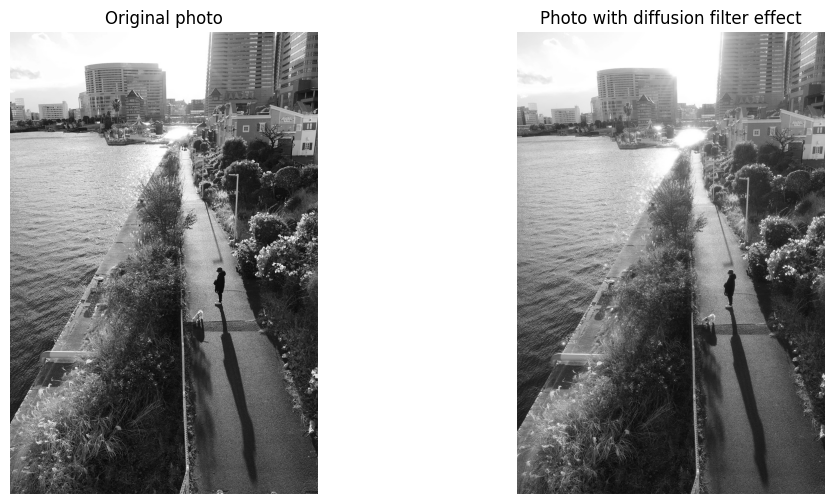

In [25]:
# Source: https://www.google.com/url?sa=i&url=https%3A%2F%2Fricohgr.eu%2Fen-at%2Fpages%2Fricoh-gr-iiix-hdf&psig=AOvVaw33VwZpwYV2WhkdA7p9RYPI&ust=1742047679003000&source=images&cd=vfe&opi=89978449&ved=0CBcQjhxqFwoTCMCdprrfiYwDFQAAAAAdAAAAABAE

plt.figure(figsize=(12, 6))

# Display the "Photo with diffusion filter effect"
plt.subplot(1, 2, 2)
plt.imshow(image_diff)  # or remove cmap if it's a color image
plt.title("Photo with diffusion filter effect")
plt.axis('off')

# Display the "Original photo"
plt.subplot(1, 2, 1)
plt.imshow(image_org)  # or remove cmap if it's a color image
plt.title("Original photo")
plt.axis('off')


plt.show()

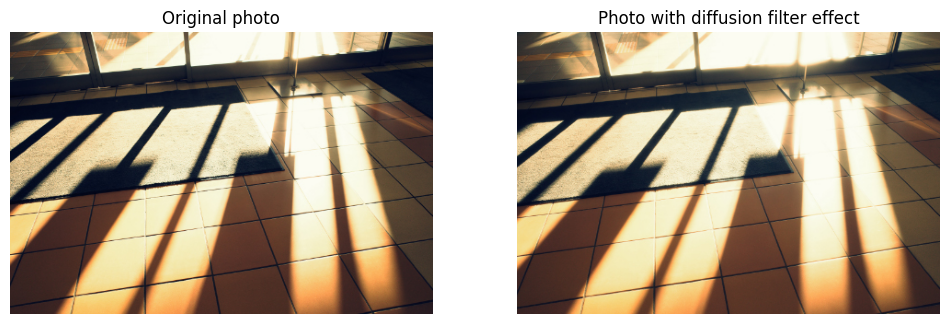

In [26]:
# Source: https://camera.co.id/product/ricoh-gr-iii-x-hdf/

plt.figure(figsize=(12, 6))
# Display the "Photo with diffusion filter effect"
plt.subplot(1, 2, 2)
plt.imshow(image_diff_2)  # or remove cmap if it's a color image
plt.title("Photo with diffusion filter effect")
plt.axis('off')

# Display the "Original photo"
plt.subplot(1, 2, 1)
plt.imshow(image_org_2)  # or remove cmap if it's a color image
plt.title("Original photo")
plt.axis('off')


plt.show()

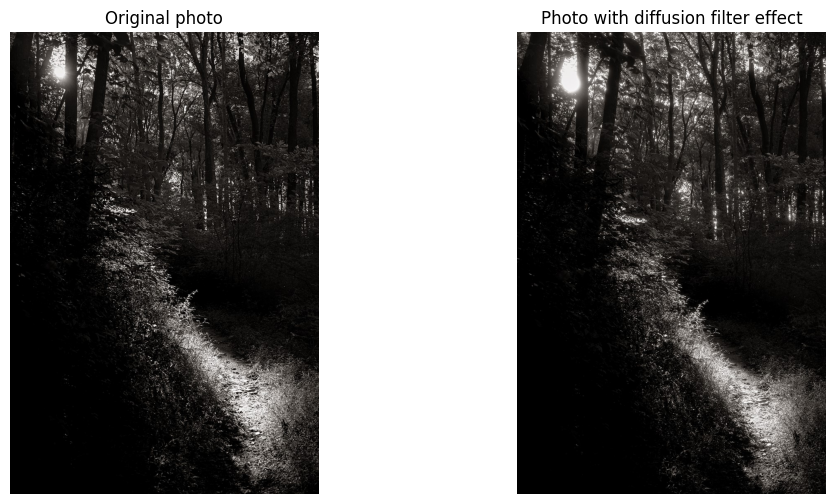

In [27]:
# Source: https://www.dpreview.com/forums/thread/4772328

plt.figure(figsize=(12, 6))
# Display the "Photo with diffusion filter effect"
plt.subplot(1, 2, 2)
plt.imshow(image_diff_3)  # or remove cmap if it's a color image
plt.title("Photo with diffusion filter effect")
plt.axis('off')

# Display the "Original photo"
plt.subplot(1, 2, 1)
plt.imshow(image_org_3)  # or remove cmap if it's a color image
plt.title("Original photo")
plt.axis('off')


plt.show()

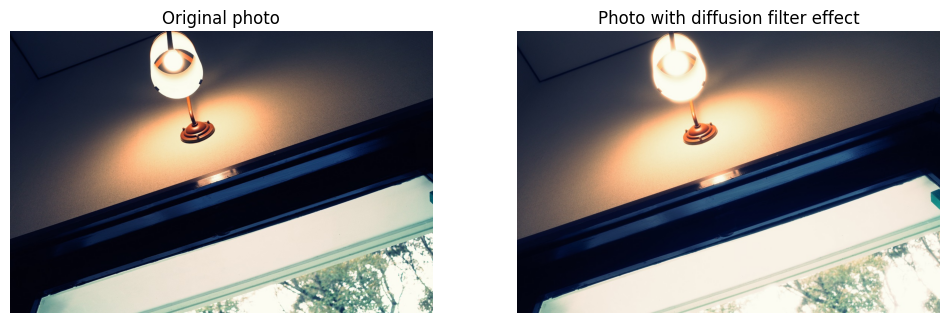

In [28]:
# Source: https://www.grblog.jp/en/article/7282/

plt.figure(figsize=(12, 6))
# Display the "Photo with diffusion filter effect"
plt.subplot(1, 2, 2)
plt.imshow(image_diff_4)  # or remove cmap if it's a color image
plt.title("Photo with diffusion filter effect")
plt.axis('off')

# Display the "Original photo"
plt.subplot(1, 2, 1)
plt.imshow(image_org_4)  # or remove cmap if it's a color image
plt.title("Original photo")
plt.axis('off')


plt.show()

## 2. Gaussian kernel

# Defining Gaussian Kernel Size Based on Pixel Intensity

In this notebook, we define a function that maps a pixel intensity (0–255) to a Gaussian kernel's standard deviation ($\sigma$). The kernel size is then computed as a function of $\sigma$. This adaptive mapping will allow us to emulate the diffusion filter's effect in highlight regions by applying a larger blur (i.e., a larger kernel) in brighter areas.

The Gaussian kernel is a matrix used to blur an image in a way that mimics the natural scattering of light. Its values are determined by the Gaussian (bell-curve) function:
$$\begin{align*}

G(x, y; \sigma) = \frac{1}{2\pi\sigma^2} \exp\left(-\frac{x^2 + y^2}{2\sigma^2}\right)

\end{align*}$$ 

- $\sigma$: This parameter controls the spread of the blur. A small sigma produces a tight, localized blur, while a larger sigma creates a broader, softer blur.
- Kernel size: will for now fix the kernel size to $3 \times 3$

By linking sigma $\sigma$ to pixel intensity, we should be able to create an adaptive filter. This means that each region of the image is blurred according to its brightness-mimicking how a diffusion filter selectively softens only the highlights. 

- **Linear mapping**: 
  An approach would be to have sigma be proportional the pixel intensity, such that:
  $$\begin{align*}
    \sigma(I) = \sigma_{\min} + \beta I
  \end{align*}$$ 

- **Sigmoid mapping**: Around a chosen midpoint $I_0$, the function increases rapidly, applying a stronger diffusion effect only when intensities are high. For very high $I$, the function saturates near $\sigma_{\text{max}}$, preventing sigma from increasing indefinitely. For low values of $I$, $\sigma(I)$ remains close to $\sigma_{\text{min}}$. This means dark areas are kept sharp with little diffusion.
 $$\begin{align*}
\sigma(I) = \sigma_{\min} + \frac{\sigma_{\max} - \sigma_{\min}}{1 + \exp\left(-k\, (I - I_0)\right)}
\end{align*}$$  




In [29]:
def linear_sigma_from_intensity(intensity, base_sigma=1.0, beta=0.01):
    """
    Computes sigma (standard deviation) for the Gaussian kernel based on pixel intensity.
    
    Args:
        intensity (float): Pixel intensity (assumed to be in the 0-255 range).
        base_sigma (float): The base sigma value.
        beta (float): A scaling factor to adjust sigma based on intensity.
        
    Returns:
        sigma (float): The computed sigma value.
    """
    sigma = base_sigma + beta * intensity
    return sigma


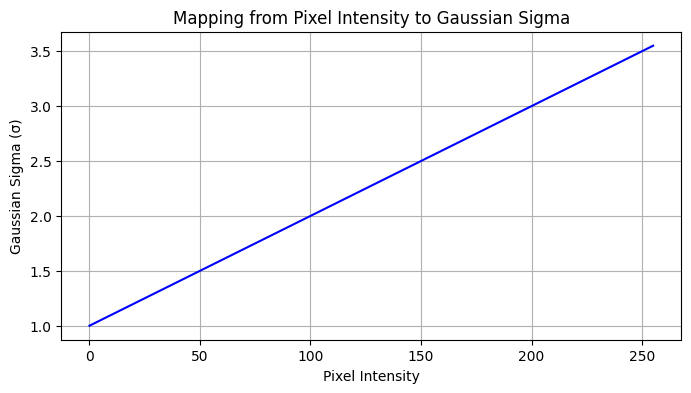

In [30]:
intensities = np.linspace(0, 255, 256)
sigmas = [linear_sigma_from_intensity(i) for i in intensities]

plt.figure(figsize=(8, 4))
plt.plot(intensities, sigmas, color='blue')
plt.xlabel("Pixel Intensity")
plt.ylabel("Gaussian Sigma (σ)")
plt.title("Mapping from Pixel Intensity to Gaussian Sigma")
plt.grid(True)
plt.show()


In [31]:
def sigmoid_sigma_from_intensity(I, sigma_min=0.5, sigma_max=5.0, k=0.2, I0=175):
    """
    Compute the Gaussian sigma using a sigmoid function with adjustable steepness,
    ensuring numerical stability.
    
    Parameters:
      I (float or np.ndarray): Pixel intensity (0-255).
      sigma_min (float): Minimum sigma for dark pixels.
      sigma_max (float): Maximum sigma for bright pixels.
      k (float): Steepness factor (higher = steeper transition).
      I0 (float): Midpoint intensity where transition occurs.
      
    Returns:
      float or np.ndarray: Computed sigma value(s).
    """
    # Convert I to float to prevent unintended integer operations
    I = np.asarray(I, dtype=np.float32)

    # Clip the base difference BEFORE multiplication to avoid large values
    delta_I = np.clip(I - I0, -1000, 1000)

    # Compute exponent safely
    exponent = -k * delta_I
    exponent = np.clip(exponent, -50, 50)  # Final clipping before exp()

    # Compute sigma using the sigmoid function
    sigma = sigma_min + (sigma_max - sigma_min) / (1 + np.exp(exponent))
    return sigma

For intensity 200, the computed sigma is 4.97


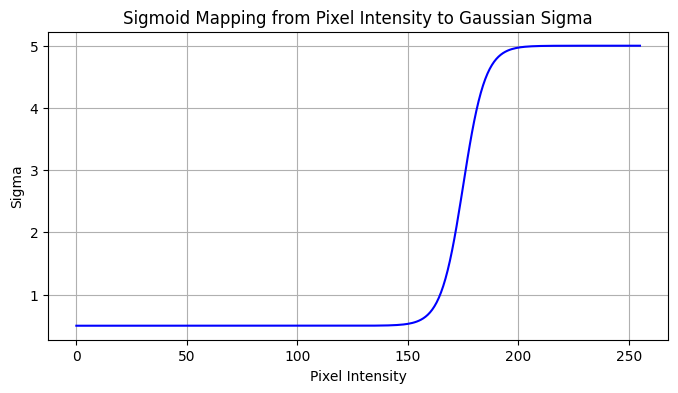

In [32]:
intensity_example = 200
sigma_example = sigmoid_sigma_from_intensity(intensity_example)
print(f"For intensity {intensity_example}, the computed sigma is {sigma_example:.2f}")

# To test on an array of intensity values:
intensities = np.linspace(0, 255, 256)
sigmas = sigmoid_sigma_from_intensity(intensities)

plt.figure(figsize=(8, 4))
plt.plot(intensities, sigmas, color='blue')
plt.xlabel("Pixel Intensity")
plt.ylabel("Sigma")
plt.title("Sigmoid Mapping from Pixel Intensity to Gaussian Sigma")
plt.grid(True)
plt.show()

In [33]:
def relu_sigma_from_intensity(I, threshold=175, sigma_max=5.0, alpha=1.0):
    """
    Compute the Gaussian sigma using a ReLU-like function with controllable steepness that activates above a certain threshold.

    Parameters:
      I (float or numpy.ndarray): Pixel intensity (0-255).
      threshold (float): Intensity threshold above which sigma starts increasing.
      sigma_max (float): Maximum sigma value when intensity is at maximum (255).
      alpha (float): Factor that controls the steepness of the increase in sigma.

    Returns:
      float or numpy.ndarray: Computed sigma value(s).
    """

    I = np.asarray(I, dtype=np.float32)  
    sigma = alpha * (sigma_max / (255.0 - threshold)) * np.maximum(I - threshold, 0)
    return sigma


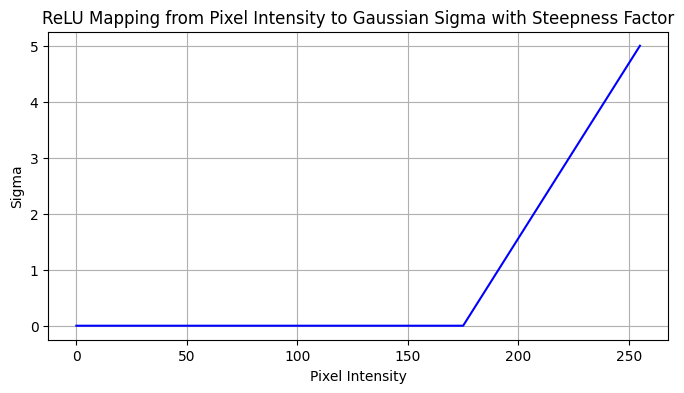

In [34]:
# Generate a range of pixel intensities from 0 to 255
intensities = np.linspace(0, 255, 256)
sigmas = relu_sigma_from_intensity(intensities, alpha=1.0)  

# Plot the function
plt.figure(figsize=(8, 4))
plt.plot(intensities, sigmas, color='blue')
plt.xlabel('Pixel Intensity')
plt.ylabel('Sigma')
plt.title('ReLU Mapping from Pixel Intensity to Gaussian Sigma with Steepness Factor')
plt.grid(True)
plt.show()

In [ ]:
img = np.zeros((C, H, W))
img = torch.from_numpy(img)
sigma = relu_sigma_from_intensity(img) #(C, H, W)
kernel = 
img = F.conv2d(img, kernel, padding=kernel_size//2, groups=C)


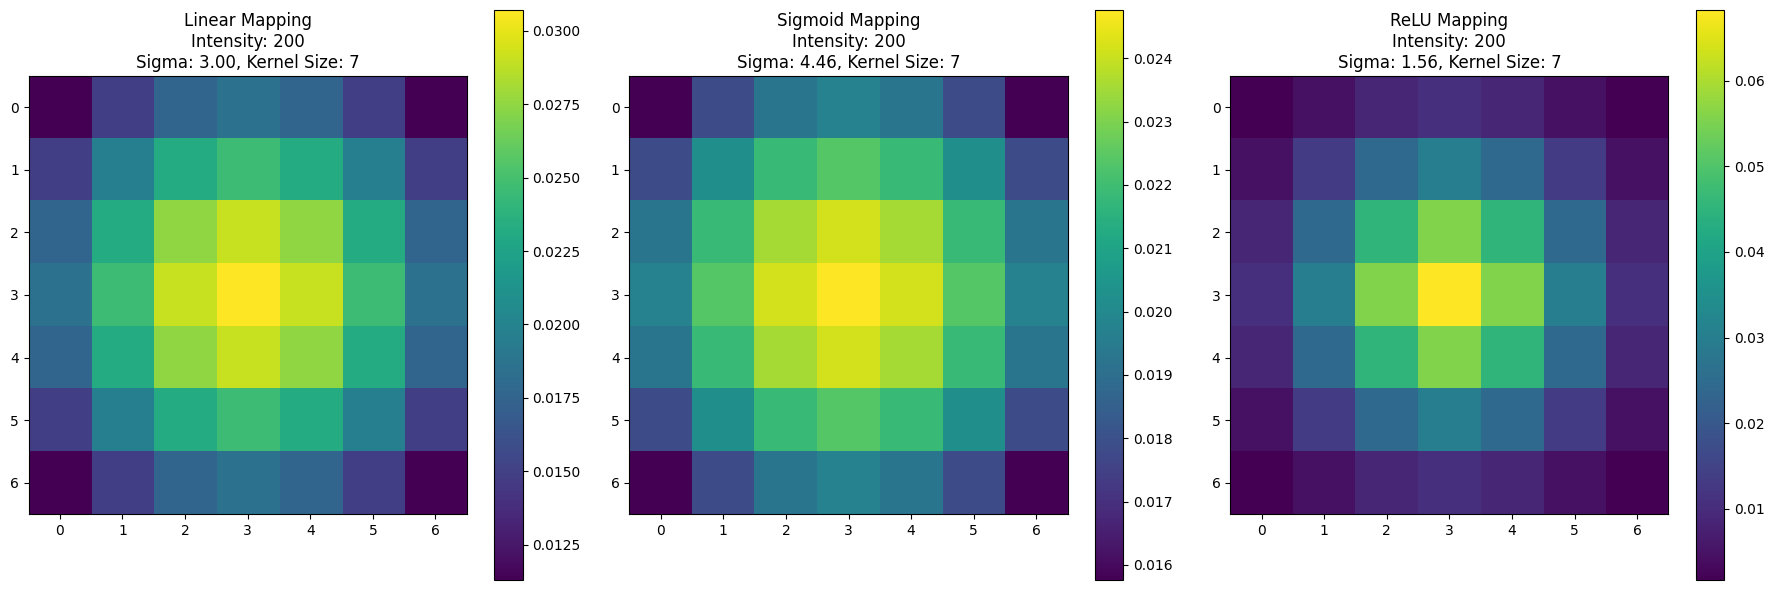

In [35]:
def get_gaussian_kernel_linear(intensity, sigma_min=1.0, beta=0.01, ksize=7):
    """
    Generate a 2D Gaussian kernel for a given pixel intensity using a linear mapping.
    
    Parameters:
      intensity (float): Pixel intensity (0-255).
      sigma_min (float): Minimum sigma for dark pixels.
      beta (float): Linear scaling factor that increases sigma with intensity.
      
    Returns:
      kernel_2d (np.ndarray): The 2D Gaussian kernel.
      sigma (float): Computed sigma value.
      ksize (int): Kernel size.
    """
    sigma = linear_sigma_from_intensity(intensity, sigma_min, beta)
    kernel_1d = cv2.getGaussianKernel(ksize, sigma)
    kernel_2d = kernel_1d * kernel_1d.T
    return kernel_2d, sigma, ksize

def get_gaussian_kernel_sigmoid(intensity, sigma_min=0.5, sigma_max=5.0, k=0.2, I0=190, ksize=7):
    """
    Generate a 2D Gaussian kernel for a given pixel intensity using a sigmoid mapping.
    
    Parameters:
      intensity (float): Pixel intensity (0-255).
      sigma_min (float): Minimum sigma for dark pixels.
      sigma_max (float): Maximum sigma for bright pixels.
      k (float): Controls the steepness of the sigmoid transition.
      I0 (float): The intensity at which the transition is most rapid.
      
    Returns:
      kernel_2d (np.ndarray): The 2D Gaussian kernel.
      sigma (float): Computed sigma value.
      ksize (int): Kernel size.
    """
    sigma = sigmoid_sigma_from_intensity(intensity, sigma_min, sigma_max, k, I0)
    kernel_1d = cv2.getGaussianKernel(ksize, sigma)
    kernel_2d = kernel_1d * kernel_1d.T
    return kernel_2d, sigma, ksize


def get_gaussian_kernel_relu(intensity, threshold=175, sigma_max=5.0, alpha=1.0, ksize=7):
    """
    Generate a 2D Gaussian kernel for a given pixel intensity using a ReLU-like mapping.

    Parameters:
      intensity (float): Pixel intensity (0-255).
      threshold (float): Intensity threshold above which sigma starts increasing linearly.
      sigma_max (float): Maximum sigma value at maximum intensity (255).
      alpha (float): Factor that controls the steepness of the increase in sigma.
      ksize (int): Kernel size, fixed at 3x3.

    Returns:
      kernel_2d (np.ndarray): The 2D Gaussian kernel.
      sigma (float): Computed sigma value.
      ksize (int): Kernel size (fixed at 3x3).
    """
    sigma = relu_sigma_from_intensity(intensity, threshold, sigma_max, alpha)
    # Generate the Gaussian kernel
    if sigma > 0:
        kernel_1d = cv2.getGaussianKernel(ksize, sigma)
        kernel_2d = kernel_1d * kernel_1d.T
    else:
        kernel_2d = np.zeros((ksize, ksize))
        kernel_2d[ksize//2, ksize//2] = 1 

    return kernel_2d, sigma, ksize

intensity_example = 200

kernel_linear, sigma_linear, ksize_linear = get_gaussian_kernel_linear(intensity_example)
kernel_sigmoid, sigma_sigmoid, ksize_sigmoid = get_gaussian_kernel_sigmoid(intensity_example)
kernel_relu, sigma_relu, ksize_relu = get_gaussian_kernel_relu(intensity_example)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(kernel_linear, cmap='viridis')
plt.colorbar()
plt.title(f"Linear Mapping\nIntensity: {intensity_example}\nSigma: {sigma_linear:.2f}, Kernel Size: {ksize_linear}")

plt.subplot(1, 3, 2)
plt.imshow(kernel_sigmoid, cmap='viridis')
plt.colorbar()
plt.title(f"Sigmoid Mapping\nIntensity: {intensity_example}\nSigma: {sigma_sigmoid:.2f}, Kernel Size: {ksize_sigmoid}")

plt.subplot(1, 3, 3)
plt.imshow(kernel_relu, cmap='viridis')
plt.colorbar()
plt.title(f"ReLU Mapping\nIntensity: {intensity_example}\nSigma: {sigma_relu:.2f}, Kernel Size: {ksize_sigmoid}")

plt.tight_layout()
plt.show() 

In [36]:
import torch

import torch.nn.functional as F

def apply_adaptive_blur_color(image, mapping_function, **kwargs):
  """
  Apply an adaptive Gaussian blur to a colored image using PyTorch for convolution.
  For each pixel, the kernel is computed based on the pixel's intensity (from the grayscale version)
  using the provided mapping_function. The kernel is then applied to each color channel separately.
  
  Parameters:
    image (np.ndarray): Input color image in BGR format.
    mapping_function (callable): Function that computes a Gaussian kernel from pixel intensity.
    **kwargs: Additional parameters for the mapping_function (e.g., threshold, sigma_max, alpha).
    
  Returns:
    np.ndarray: The adaptively blurred color image.
  """
  image_float = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray_tensor = torch.tensor(gray, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

  h, w = gray.shape
  ksize = 7
  half = ksize // 2

  output = torch.zeros_like(image_float)

  unique_intensities = torch.unique(gray_tensor)
  for intensity in unique_intensities:
    kernel, sigma, _ = mapping_function(intensity.item(), ksize=ksize, **kwargs)
    kernel_tensor = torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    mask = (gray_tensor == intensity).float()

    # Apply convolution to each channel separately
    for c in range(image_float.shape[1]):
      channel = image_float[:, c:c+1, :, :]
      blurred_channel = F.conv2d(channel, kernel_tensor, padding=half)
      output[:, c:c+1, :, :] += blurred_channel * mask

  output = (output.squeeze(0).permute(1, 2, 0) * 255.0).clip(0, 255).byte().numpy()
  return output




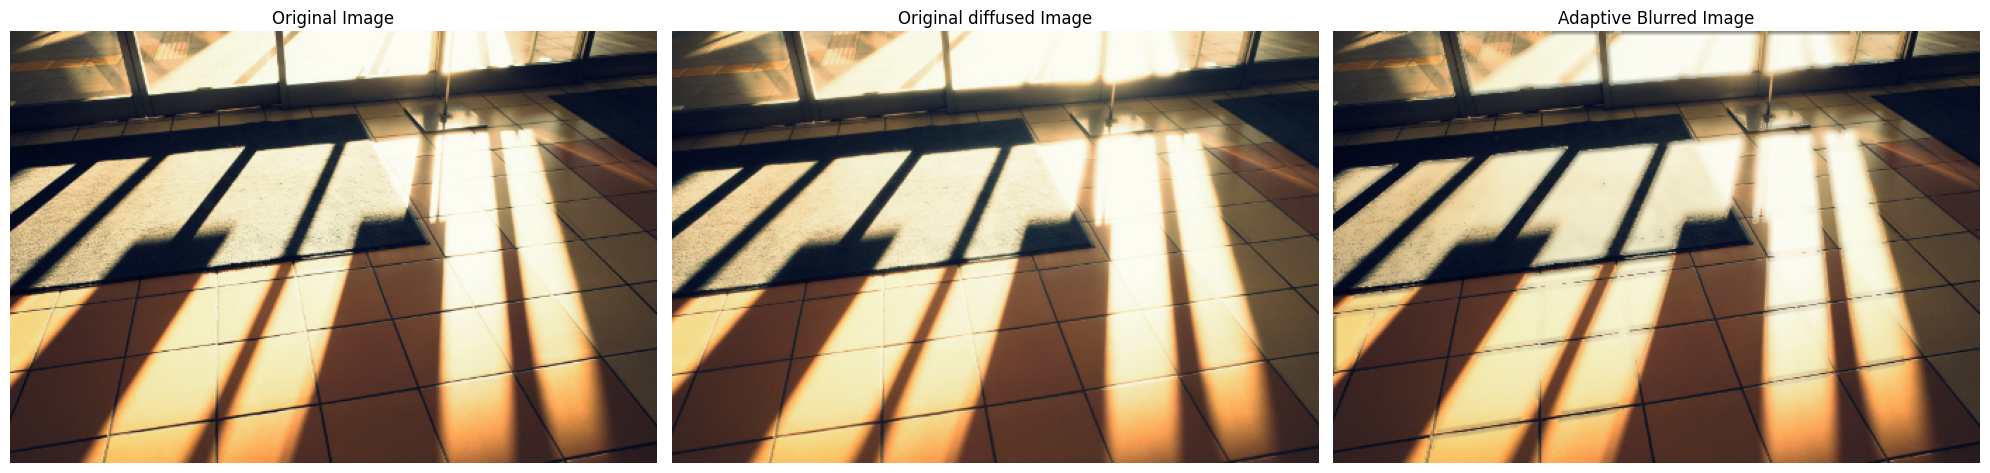

In [37]:
# ReLU

blurred_image1 = apply_adaptive_blur_color(image_org_2, get_gaussian_kernel_relu, sigma_max= 20, alpha=2)


plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.imshow(image_org_2)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(image_diff_2)
plt.title("Original diffused Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(blurred_image1)
plt.title("Adaptive Blurred Image")
plt.axis("off")

plt.tight_layout()
plt.show()

(np.float64(0.0), np.float64(460.0), np.float64(307.0), np.float64(0.0))

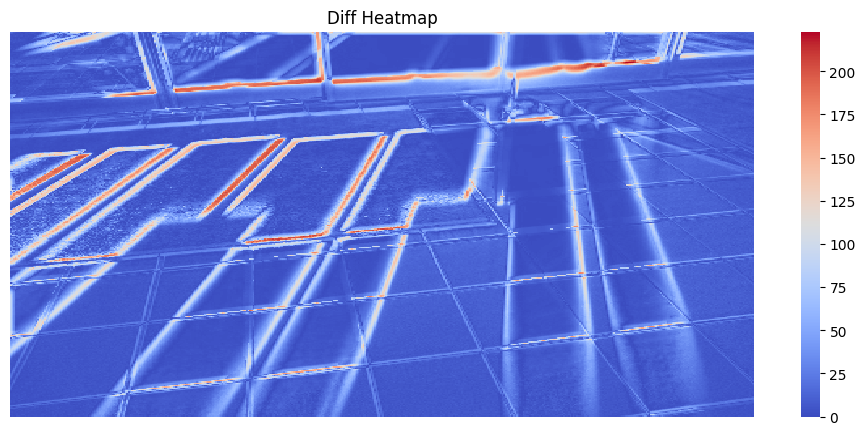

In [38]:
difference = np.abs(image_diff_2.astype(float) - blurred_image1.astype(float))

plt.figure(figsize=(12, 5))
if difference.ndim == 3:  # If the image is mistakenly in RGB, convert to grayscale
    # Convert to float32 or uint8 before using cv2.cvtColor
    difference = difference.astype(np.float32)  # Or use .astype(np.uint8) if values are in [0, 255]
    diff_image = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
else:
    diff_image = difference  # Already grayscale

sns.heatmap(diff_image, cmap='coolwarm', cbar=True)
plt.title("Diff Heatmap")
plt.axis("off")

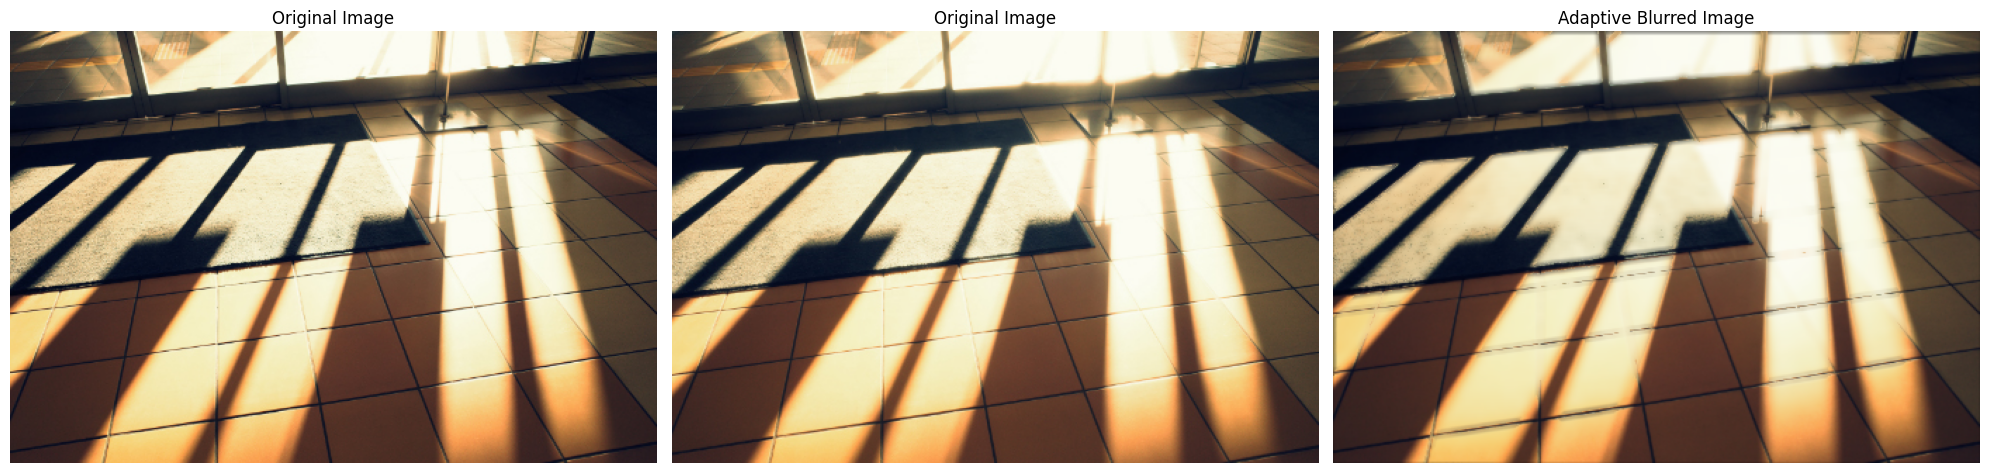

In [39]:

# Sigmoid

blurred_image2 = apply_adaptive_blur_color(image_org_2, get_gaussian_kernel_sigmoid)

plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.imshow(image_org_2)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(image_diff_2)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(blurred_image2)
plt.title("Adaptive Blurred Image")
plt.axis("off")

plt.tight_layout()
plt.show()

(np.float64(0.0), np.float64(460.0), np.float64(307.0), np.float64(0.0))

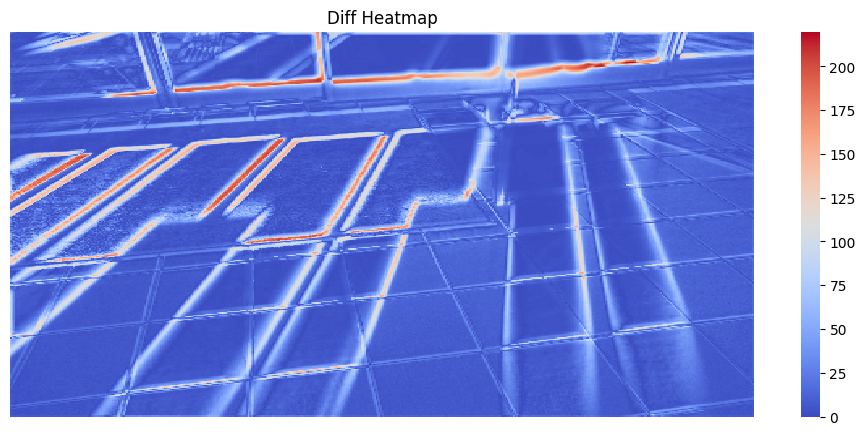

In [40]:
difference = np.abs(image_diff_2.astype(float) - blurred_image2.astype(float))

plt.figure(figsize=(12, 5))
if difference.ndim == 3:  # If the image is mistakenly in RGB, convert to grayscale
    # Convert to float32 or uint8 before using cv2.cvtColor
    difference = difference.astype(np.float32)  # Or use .astype(np.uint8) if values are in [0, 255]
    diff_image = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
else:
    diff_image = difference  # Already grayscale

sns.heatmap(diff_image, cmap='coolwarm', cbar=True)
plt.title("Diff Heatmap")
plt.axis("off")

(np.float64(0.0), np.float64(460.0), np.float64(307.0), np.float64(0.0))

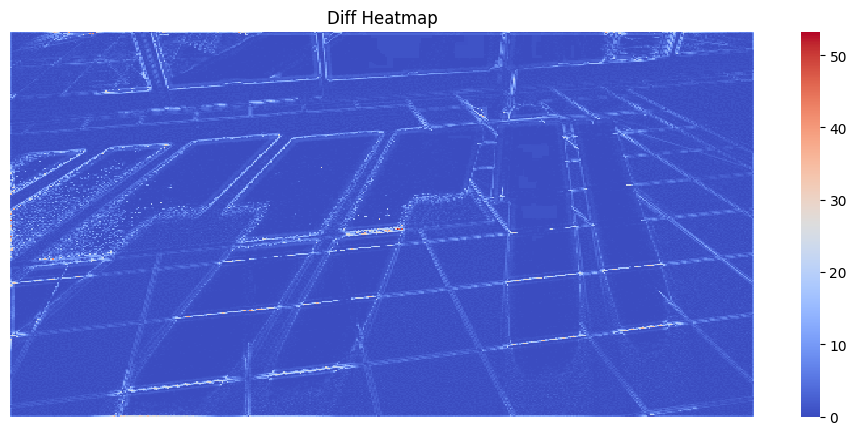

In [41]:
difference = np.abs(blurred_image1.astype(float) - blurred_image2.astype(float))

plt.figure(figsize=(12, 5))
if difference.ndim == 3:  # If the image is mistakenly in RGB, convert to grayscale
    # Convert to float32 or uint8 before using cv2.cvtColor
    difference = difference.astype(np.float32)  # Or use .astype(np.uint8) if values are in [0, 255]
    diff_image = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
else:
    diff_image = difference  # Already grayscale

sns.heatmap(diff_image, cmap='coolwarm', cbar=True)
plt.title("Diff Heatmap")
plt.axis("off")

In [42]:
# print(os.path.exists("first-filter-dataset/IMG_7957.CR2"))
# # i want to adapt the apply adaptive kernel so that i can apply it to raw pictures
# # load IMG_7955_diff.CR2
# test_diff = load_image("first-filter-dataset/IMG_7955_diff.CR2")
# # load IMG_7955.CR2
# test_org = load_image("first-filter-dataset/IMG_7957.CR2")
# # apply adaptive blur to test_org
# # using relu

# blurred_image = apply_adaptive_blur_color(test_org, get_gaussian_kernel_relu)

# plt.figure(figsize=(20, 8))

# plt.subplot(1, 3, 1)
# plt.imshow(test_org)
# plt.title("Original Image")
# plt.axis("off")

# plt.subplot(1, 3, 2)
# plt.imshow(test_diff)
# plt.title("Original diffused Image")
# plt.axis("off")

# plt.subplot(1, 3, 3)
# plt.imshow(blurred_image)
# plt.title("Adaptive Blurred Image")
# plt.axis("off")

# plt.tight_layout()
# plt.show()

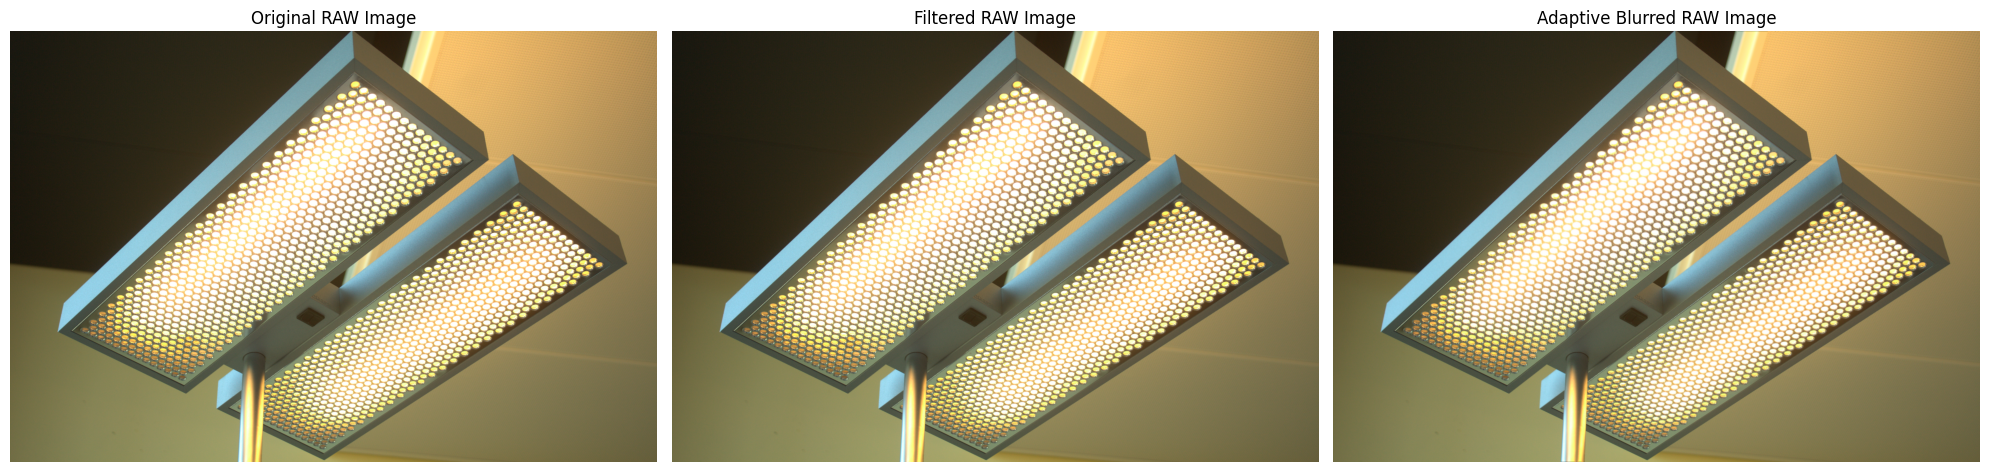

In [43]:
# Load the RAW image
DIR = "data/dataset_raw/"
raw_image = load_image(f"{DIR}filter_long_exp/photo_1.CR2")
raw_image_filter = load_image(f"{DIR}filter_long_exp/photo_1.CR2")

# Apply adaptive blur using the desired kernel mapping function (e.g., ReLU)
blurred_raw_image = apply_adaptive_blur_color(raw_image, get_gaussian_kernel_relu, sigma_max=20, alpha=2)

# Display the original and blurred images
plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.imshow(raw_image)
plt.title("Original RAW Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(raw_image)
plt.title("Filtered RAW Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(blurred_raw_image)
plt.title("Adaptive Blurred RAW Image")
plt.axis("off")

plt.tight_layout()
plt.show()